In [1]:
import numpy as np
import matplotlib.pyplot as plt

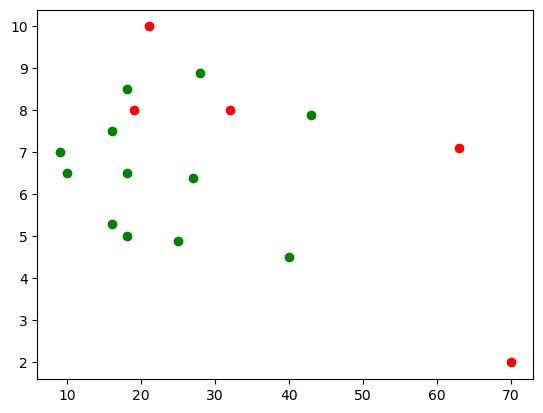

In [2]:
alter = np.array([16, 18, 18, 18, 19, 21, 40, 9, 10, 16, 32, 43, 70, 63, 25, 27, 28])
sportlichkeit = np.array([7.5, 8.5, 6.5, 5.0, 8.0, 10, 4.5, 7.0, 6.5, 5.3, 8.0, 7.9, 2.0, 7.1, 4.9, 6.4, 8.9])
mag_patties = np.array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1])

training_data = np.c_[alter, sportlichkeit, mag_patties]
plt.scatter(alter[mag_patties == 0], sportlichkeit[mag_patties == 0], c="red")
plt.scatter(alter[mag_patties == 1], sportlichkeit[mag_patties == 1], c="green")

In [3]:
def is_numeric(value):
    return isinstance(value, (int, float))

In [4]:
class Question: # Note: The Question only works if there is no ordinal categorical data

    def __init__(self, feature, value):
        self.feature = feature
        self.value = value

    def match(self, selected_row):
        val = selected_row[self.feature]

        if(is_numeric(val)):
            return val >= self.value
        else:
            return val == self.value    

In [5]:
def partition(rows, question):
    
    true_rows, false_rows = [], []

    for row in rows:
        if(question.match(row)):
            true_rows.append(row)
        else:
            false_rows.append(row)
        
    return true_rows, false_rows

In [6]:
def class_counts(rows):
    counts = {}
    for row in rows:
        label = row[-1] # Label/Class
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [7]:
def gini_impurity(rows):
    impurity = 1

    counts = class_counts(rows)

    for label in counts:
        prob_of_label = counts[label] / float(len(rows))
        impurity -= prob_of_label**2 

    return impurity


In [8]:
def information_gain(current_impurity, true_rows, false_rows):
    p = float(len(true_rows)) / (len(true_rows) + len(false_rows))
    return current_impurity - p * gini_impurity(true_rows) - (1-p) * gini_impurity(false_rows)

In [9]:
def find_best_split(rows): # /Find the best question to ask

    best_gain = 0
    best_question = None
    best_true_rows = []
    best_false_rows = []
    current_impurity = gini_impurity(rows)
    n_features = len(rows[0]) - 1

    for feature in range(n_features):

        values = set(row[feature] for row in rows)
        
        for value in values:

            question = Question(feature, value)

            true_rows, false_rows = partition(rows, question)

            if(len(true_rows) == 0 or len(false_rows) == 0):
                continue

            gain = information_gain(current_impurity, true_rows, false_rows)

            if(gain > best_gain):
                best_gain = gain
                best_question = question
                best_true_rows = true_rows
                best_false_rows = false_rows

    return best_gain, best_question, best_true_rows, best_false_rows



In [10]:
class Decision_Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [11]:
class Leaf:
    def __init__(self, rows):
        self.predictions = class_counts(rows) # Occurences of each label

In [12]:
def build_tree(rows, current_depth, max_depth):

    if(current_depth == max_depth):
        return Leaf(rows)

    gain, question, true_rows, false_rows = find_best_split(rows)

    if(gain == 0):
        return Leaf(rows)

    true_branch = build_tree(true_rows, current_depth+1, max_depth)
    false_branch = build_tree(false_rows, current_depth+1, max_depth)

    return Decision_Node(question, true_branch, false_branch) 

In [13]:
def predict(rows, root):
    def classify(row, current_node):
        if(isinstance(current_node, Leaf)):
            return current_node.predictions
        
        if(current_node.question.match(row)):
            return classify(row, current_node.true_branch)
        else:
            return classify(row, current_node.false_branch)
        
    predictions = []
    for row in rows:
        predictions.append(classify(row, root))
    for i in range(len(predictions)):
        predictions[i] = max(predictions[i], key=predictions[i].get)

    return predictions

In [ ]:
decision_tree = build_tree(training_data, 0, 5)

print("Wie alt bist du?")
user_alter = float(input())
print("Wie sportlich bist du? (Auf einer Skala von 1 bis 10)")
user_sportlichkeit = float(input())

print(user_alter, user_sportlichkeit)
final_predictions = predict([[user_alter, user_sportlichkeit], [user_alter-1, user_sportlichkeit], [user_alter, user_sportlichkeit-1]], decision_tree)

print(f"Final predictions: {final_predictions}")

for final_prediction in final_predictions:
    if(final_prediction == 1.0):
        print("Du wirst wahrscheinlich Patties mögen!")
    elif(final_prediction == 0.0):
        print("Du wirst wahrscheinlich Patties NICHT mögen!")